## 1: Bandits

### 1.1A: Epsilon Greedy

In [1]:
import numpy as np
import sys

In [12]:
if "../" not in sys.path:
    sys.path.append("../") 

from lib.envs.bandit import BanditEnv
from lib.simulation import Experiment

In [2]:
#Policy interface
class Policy:
    #num_actions: (int) Number of arms [indexed by 0 ... num_actions-1]
    def __init__(self, num_actions):
        self.num_actions = num_actions
    
    def act(self):
        pass
        
    def feedback(self, action, reward):
        pass

In [3]:
#Greedy policy
class Greedy(Policy):
    def __init__(self, num_actions):
        Policy.__init__(self, num_actions)
        self.name = "Greedy"
        self.total_rewards = np.zeros(num_actions, dtype = np.longdouble)
        self.total_counts = np.zeros(num_actions, dtype = np.longdouble)
    
    def act(self):
        current_averages = np.divide(self.total_rewards, self.total_counts, where = self.total_counts > 0)
        current_averages[self.total_counts <= 0] = 0.5      #Correctly handles Bernoulli rewards; over-estimates otherwise
        current_action = np.argmax(current_averages)
        return current_action
        
    def feedback(self, action, reward):
        self.total_rewards[action] += reward
        self.total_counts[action] += 1

Now let's implement an epsilon greedy policy based on the policy interface. The epsilon greedy policy will make sure we explore (i.e taking random actions) as set by the epsilon value, and take the most rewarding action (i.e greedy) the rest of the times. This is implemented in the act() function. 

In [4]:
#Epsilon Greedy policy
class EpsilonGreedy(Greedy):
    def __init__(self, num_actions, epsilon):
        Greedy.__init__(self, num_actions)
        if (epsilon is None or epsilon < 0 or epsilon > 1):
            print("EpsilonGreedy: Invalid value of epsilon", flush = True)
            sys.exit(0)
            
        self.epsilon = epsilon
        self.name = "Epsilon Greedy"
    
    def act(self):
        choice = None
        if self.epsilon == 0:
            choice = 0
        elif self.epsilon == 1:
            choice = 1
        else:
            choice = np.random.binomial(1, self.epsilon)
            
        if choice == 1:
            return np.random.choice(self.num_actions)
        else:
            current_averages = np.divide(self.total_rewards, self.total_counts, where = self.total_counts > 0)
            current_averages[self.total_counts <= 0] = 0.5  #Correctly handles Bernoulli rewards; over-estimates otherwise
            current_action = np.argmax(current_averages)
            return current_action
        

Now let's prepare the simulation. We'll use a different seed and have 10 arms/actions instead of 5.

In [21]:
evaluation_seed = 5016
num_actions = 10
trials = 10000
distribution = "bernoulli"
#distribution = "normal"

First, let's use epsilon = 0. Run the simulation and observe the results.

Distribution: bernoulli [0.93160258 0.10144645 0.65359868 0.39412646 0.67036346 0.46602165
 0.95371529 0.87460326 0.22253422 0.11576875]
Optimal arm: 6


<Figure size 720x360 with 0 Axes>

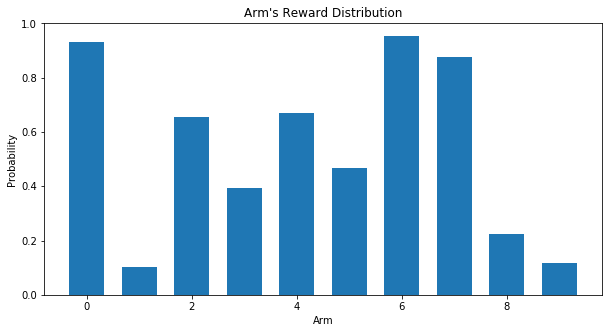

--------------------------------------------------
Policy: Epsilon Greedy 
Average Reward: 0.8991 
Average Regret: 0.053713958739945056
Arm pulls: [4616.  119.   87.   95.   90.   93. 4575.  101.  114.  110.]


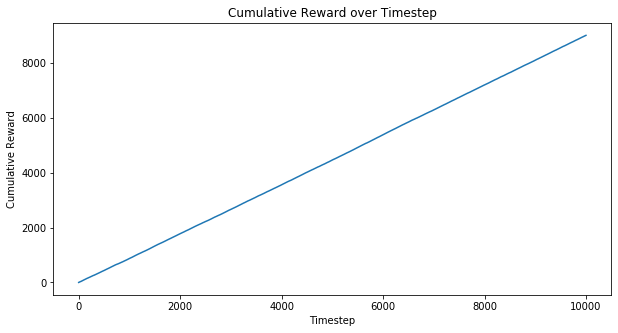

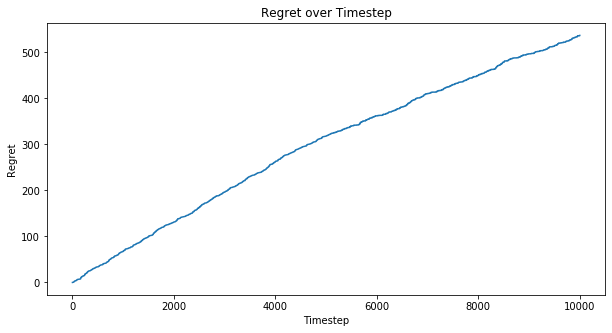

In [6]:
epsilon = 0.1
env = BanditEnv(num_actions, distribution, evaluation_seed)
agent = EpsilonGreedy(num_actions, epsilon)
experiment = Experiment(env, agent)
experiment.run_bandit(trials)

What about if epsilon = 1? Run the simulation again and observe the results.

Now, try several different number of epsilons (0.05, 0.1, 0.15). Run the simulations and observe the results.

Which epsilon performs best with this problem?

Now let's prepare another simulation by setting a different seed. 

In [26]:
evaluation_seed = 1239
num_actions = 10
trials = 10000
distribution = "bernoulli"

Try the range of epsilons again (0, 0.05, 0.1, 0.15, 1), run the simulations and observe the results.

Which epsilon performs best with this problem?

What do you learn about setting the epsilon value?

In [6]:
def plot_rewards_regrets(stats, smoothing_window=1, hideplot=False):
    # Plot the cumulative reward over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.cumulative_rewards)
    plt.xlabel("Timestep")
    plt.ylabel("Cumulative Reward")
    plt.title("Cumulative Reward over Timestep")
    if hideplot:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the regret over time
    fig2 = plt.figure(figsize=(10,5))
    plt.plot(stats.regrets)
    plt.xlabel("Timestep")
    plt.ylabel("Regret")
    plt.title("Regret over Timestep")
    if hideplot:
        plt.close(fig2)
    else:
        plt.show(fig2)
             
    return fig1, fig2 

In [7]:
from collections import namedtuple
TimestepStats = namedtuple("Stats",["cumulative_rewards", "regrets"])

In [14]:
#import lib.plotting as plotting
from matplotlib import pyplot as plt
from matplotlib import pylab

class Experiments(object):
    def __init__(self, env, agent):
        
        self.env = env
        self.agent = agent
        
        self.episode_length = np.array([0])
        self.episode_reward = np.array([0])
        
        

    def run_bandits(self, max_number_of_trials=1000, display_frequency=1):
        
        print("Distribution:", self.env.distribution, self.env.reward_parameters, flush = True)
        print("Optimal arm:", self.env.optimal_arm, flush = True)
        
        stats = TimestepStats(
            cumulative_rewards=np.zeros(max_number_of_trials),
            regrets=np.zeros(max_number_of_trials))   
            
        cumulative_reward = 0.0
        cumulative_regret = 0.0
        
        for trial in range(max_number_of_trials):
            action = self.agent.act()
            
            _ , reward, done, _ = self.env.step(action)       
            self.agent.feedback(action, reward)
            cumulative_reward += reward

            gap = self.env.compute_gap(action)
            if action != self.env.optimal_arm:
                cumulative_regret += gap

            stats.cumulative_rewards[trial] = cumulative_reward
            stats.regrets[trial] = cumulative_regret
         
        return stats

Distribution: bernoulli [0.5061565  0.74836123 0.53065236 0.37446716 0.88168477 0.83849367
 0.3951277  0.13217982 0.44509856 0.03459039]
Optimal arm: 4
--------------------------------------------------
Policy: Epsilon Greedy 
Average Reward: 0.8409 
Average Regret: 0.03955176021043847
Arm pulls: [  94.   91.  106.   91. 9106.  101.   93.  106.  107.  105.]


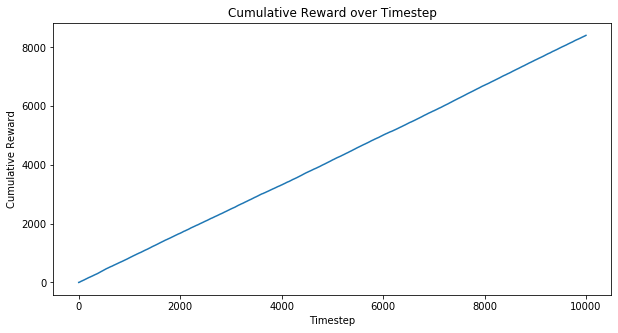

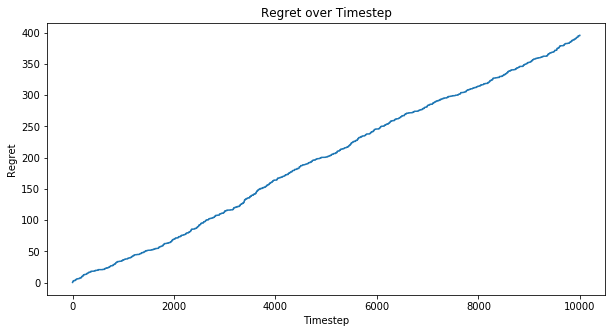

In [11]:
epsilon = 0.1
env = BanditEnv(num_actions, distribution, evaluation_seed)
agent = EpsilonGreedy(num_actions, epsilon)
experiments = Experiments(env, agent)
experiments.run_bandits(trials)

In [27]:
env = BanditEnv(num_actions, distribution, evaluation_seed)
stats_dict = {}
for e in [0, 0.05, 0.1, 0.15, 1]:
    agent = EpsilonGreedy(num_actions, epsilon)
    experiments = Experiments(env, agent)
    stats_dict[e] = experiments.run_bandits(trials)

Distribution: bernoulli [0.5061565  0.74836123 0.53065236 0.37446716 0.88168477 0.83849367
 0.3951277  0.13217982 0.44509856 0.03459039]
Optimal arm: 4
Distribution: bernoulli [0.5061565  0.74836123 0.53065236 0.37446716 0.88168477 0.83849367
 0.3951277  0.13217982 0.44509856 0.03459039]
Optimal arm: 4
Distribution: bernoulli [0.5061565  0.74836123 0.53065236 0.37446716 0.88168477 0.83849367
 0.3951277  0.13217982 0.44509856 0.03459039]
Optimal arm: 4
Distribution: bernoulli [0.5061565  0.74836123 0.53065236 0.37446716 0.88168477 0.83849367
 0.3951277  0.13217982 0.44509856 0.03459039]
Optimal arm: 4
Distribution: bernoulli [0.5061565  0.74836123 0.53065236 0.37446716 0.88168477 0.83849367
 0.3951277  0.13217982 0.44509856 0.03459039]
Optimal arm: 4


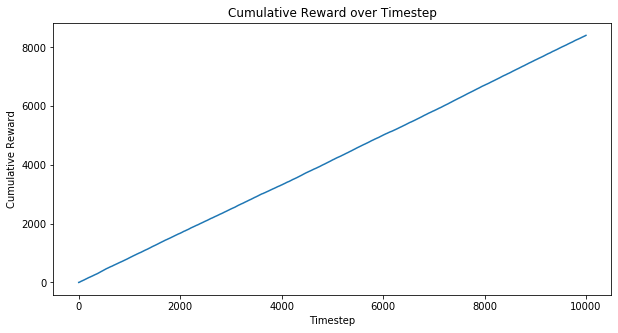

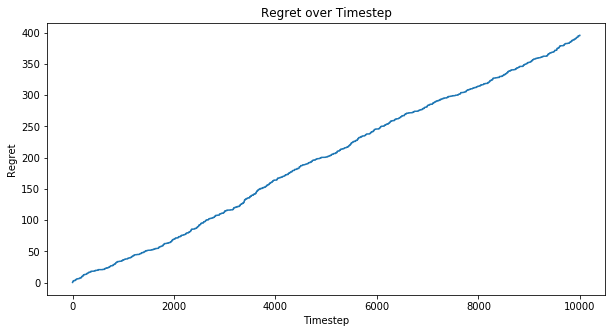

(<Figure size 720x360 with 1 Axes>, <Figure size 720x360 with 1 Axes>)

In [28]:
plot_rewards_regrets(stats_dict[0])

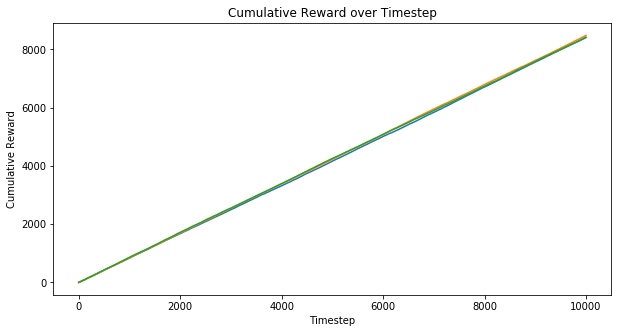

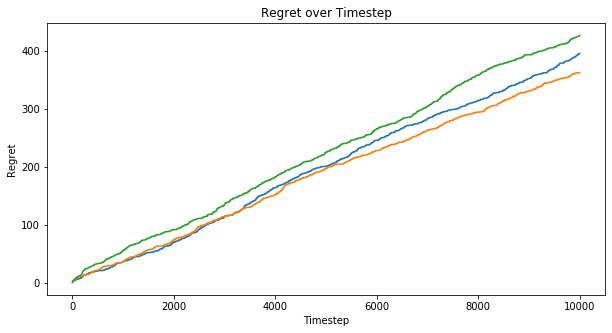

In [29]:
fig1 = plt.figure(figsize=(10,5))
plt.plot(stats_dict[0].cumulative_rewards)
plt.plot(stats_dict[0.15].cumulative_rewards)
plt.plot(stats_dict[1].cumulative_rewards)
plt.xlabel("Timestep")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward over Timestep")
plt.show(fig1)

# Plot the regret over time
fig2 = plt.figure(figsize=(10,5))
plt.plot(stats_dict[0].regrets)
plt.plot(stats_dict[0.15].regrets)
plt.plot(stats_dict[1].regrets)
plt.xlabel("Timestep")
plt.ylabel("Regret")
plt.title("Regret over Timestep")
plt.show(fig2)